Filter reference: https://github.com/HuiLin0220/StenUNet/tree/master

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.fft as fft
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torchvision.transforms.functional as TF
from PIL import Image
import skimage.color
import matplotlib.pyplot as plt

**Preprocess the dataset**

In [5]:
plt.rcParams['image.cmap'] = "gray"

In [6]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        mask_name = self.data.iloc[idx, 1]
        image = Image.open(img_name).convert('RGB')
        mask = Image.open(mask_name).convert('L')
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        mask = (mask > 0.5).float()
        return image, mask

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_csv_file = "/home/maitha.alnaqbi/Desktop/ai702_project/Coronary/train/train_data.csv"
test_csv_file = "/home/maitha.alnaqbi/Desktop/ai702_project/Coronary/test/test_data.csv"
val_csv_file = "/home/maitha.alnaqbi/Desktop/ai702_project/Coronary/val/val_data.csv"

train_dataset = CustomDataset(train_csv_file, transform=transform)
test_dataset = CustomDataset(test_csv_file, transform=transform)
val_dataset = CustomDataset(val_csv_file, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

In [7]:
class HomomorphicFilter:
    def __init__(self, gH=1.5, gL=0.5):
        self.gH = float(gH)
        self.gL = float(gL)

    def __Duv(self, I_shape):
        P = I_shape[0] / 2
        Q = I_shape[1] / 2
        U, V = np.meshgrid(range(I_shape[0]), range(I_shape[1]), sparse=False, indexing='ij')
        Duv = (((U - P) ** 2 + (V - Q) ** 2) ** (1 / 2)).astype(np.dtype('d'))
        return Duv

    def __butterworth_filter(self, I_shape, filter_params):
        Duv = self.__Duv(I_shape)
        n = filter_params[2]
        c = filter_params[1]
        D0 = filter_params[0]
        h = 1 / (1 + ((c * Duv) / D0) ** (2 * n))
        H = (1 - h)
        return H

    def __gaussian_filter(self, I_shape, filter_params):
        Duv = self.__Duv(I_shape)
        c = filter_params[1]
        D0 = filter_params[0]
        h = np.exp((-c * (Duv ** 2) / (2 * (D0 ** 2))))
        H = (1 - h)
        return H

    def __plot_Filter(self, I, H, filter_params):
        I_shape = I.shape
        if I_shape[0] > I_shape[1]:
            plt.plot(self.__Duv(I_shape)[int(I_shape[1] / 2)], H[int(I_shape[1] / 2)])
        else:
            plt.plot(self.__Duv(I_shape)[int(I_shape[0] / 2)], H[int(I_shape[0] / 2)])

    def __apply_filter(self, I, H, params):
        if self.gH < 1 or self.gL >= 1:
            H = H
        else:
            H = ((self.gH - self.gL) * H + self.gL)
        I_filtered = H * I
        return I_filtered

    def apply_filter(self, I, filter_params=(12, 1, 2), filter_='butterworth', H=None):
        if len(I.shape) != 2:
            raise Exception('image not suitable')
        I_log = np.log1p(np.array(I, dtype='d'))
        I_fft = np.fft.fft2(I_log)
        I_fft = np.fft.fftshift(I_fft)
        if filter_ == 'butterworth':
            H = self.__butterworth_filter(I_shape=I_fft.shape, filter_params=filter_params)
        elif filter_ == 'gaussian':
            H = self.__gaussian_filter(I_shape=I_fft.shape, filter_params=filter_params)
        elif filter_ == 'external':
            if len(H.shape) != 2:
                raise Exception('Invalid ex filter')
        else:
            raise Exception('filter selected was not applied')
        I_fft_filt = self.__apply_filter(I=I_fft, H=H, params=filter_params)
        I_fft_filt = np.fft.fftshift(I_fft_filt)
        I_filt = np.fft.ifft2(I_fft_filt)
        I = np.expm1(np.real(I_filt))
        Imax = (np.max(I))
        Imin = (np.min(I))
        I = 255 * ((I - Imin) / (Imax - Imin))
        return I

def display_images(images, titles=None):
    num_images = len(images)
    if titles is None:
        titles = [f"Image {i+1}" for i in range(num_images)]
    fig, axes = plt.subplots(1, num_images, figsize=(10, 5))
    if num_images == 1:
        axes = [axes]
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

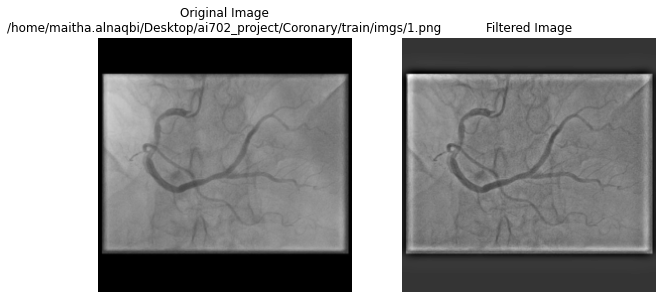

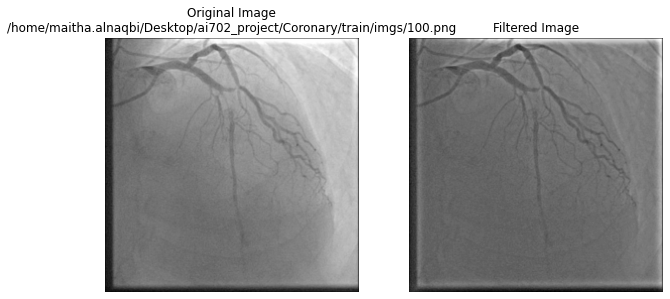

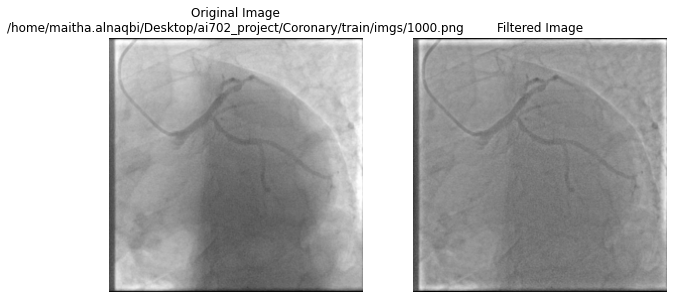

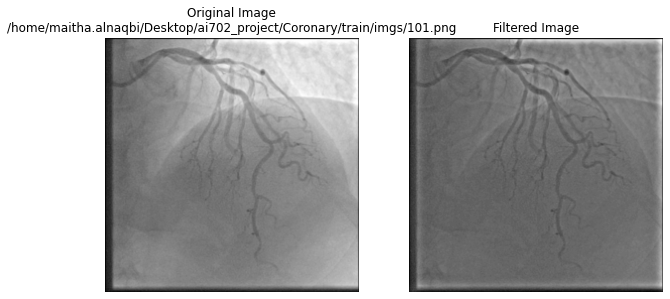

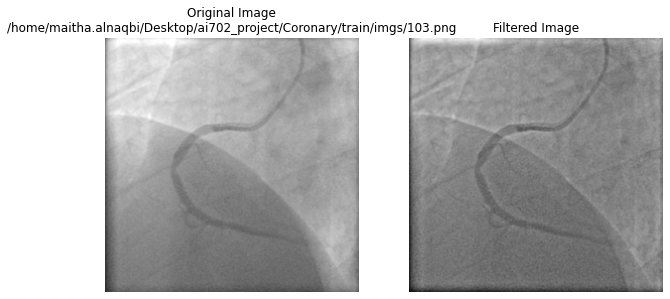

In [23]:
homomorphic_filter = HomomorphicFilter()

num_images_to_display = 5
count = 0

for images, masks in train_loader:
    for img, mask in zip(images, masks):
        if count >= num_images_to_display:
            break
        
        img_np = img.permute(1, 2, 0).numpy()
        img_gray = skimage.color.rgb2gray(img_np)
        
        filtered_img = homomorphic_filter.apply_filter(img_gray)
        image_path = train_dataset.data.iloc[count, 0]
        
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img_np)
        plt.title(f"Original Image\n{image_path}")
        plt.axis("off")
        
        plt.subplot(1, 2, 2)
        plt.imshow(filtered_img, cmap='gray')
        plt.title("Filtered Image")
        plt.axis("off")
        
        plt.show()
        
        count += 1
    if count >= num_images_to_display:
        break

In [19]:
import os
import pandas as pd
from PIL import Image

In [22]:
def apply_filter_and_save(image_path, output_dir):
    img = Image.open(image_path).convert('RGB')
    img_np = np.array(img)
    img_gray = skimage.color.rgb2gray(img_np)
    filtered_img = homomorphic_filter.apply_filter(img_gray)
    os.makedirs(output_dir, exist_ok=True)
    image_filename = os.path.basename(image_path)
    filtered_image_path = os.path.join(output_dir, image_filename)
    Image.fromarray(filtered_img.astype(np.uint8)).save(filtered_image_path)



train_csv_file = "/home/maitha.alnaqbi/Desktop/ai702_project/Coronary/train/train_data.csv"
test_csv_file = "/home/maitha.alnaqbi/Desktop/ai702_project/Coronary/test/test_data.csv"
val_csv_file = "/home/maitha.alnaqbi/Desktop/ai702_project/Coronary/val/val_data.csv"

train_output_dir = "/home/maitha.alnaqbi/Desktop/ai702_project/Coronary/train/imgs_filter"
val_output_dir = "/home/maitha.alnaqbi/Desktop/ai702_project/Coronary/val/imgs_filter"
test_output_dir = "/home/maitha.alnaqbi/Desktop/ai702_project/Coronary/test/imgs_filter"


train_data = pd.read_csv(train_csv_file)
val_data = pd.read_csv(val_csv_file)
test_data = pd.read_csv(test_csv_file)

for index, row in train_data.iterrows():
    image_path = row['image']
    apply_filter_and_save(image_path, train_output_dir)

for index, row in val_data.iterrows():
    image_path = row['image']
    apply_filter_and_save(image_path, val_output_dir)

for index, row in test_data.iterrows():
    image_path = row['image']
    apply_filter_and_save(image_path, test_output_dir)

**Create new CSV files for the preprocessed images**

For training, since we have the original and filtered images the training data size will be *2

In [24]:
import os

imgs_dir = "/home/maitha.alnaqbi/Desktop/ai702_project/Coronary/train/imgs_filter/"

for filename in os.listdir(imgs_dir):
    if filename.endswith(".png"):
        new_filename = filename.replace(".png", "_filter.png")
        
        # Rename the file
        os.rename(os.path.join(imgs_dir, filename), os.path.join(imgs_dir, new_filename))

print("Renaming complete.")

Renaming complete.


In [25]:
import csv

In [28]:
imgs_dir = "/home/maitha.alnaqbi/Desktop/ai702_project/Coronary/train/imgs/"
imgs_filter_dir = "/home/maitha.alnaqbi/Desktop/ai702_project/Coronary/train/imgs_filter/"
masks_dir = "/home/maitha.alnaqbi/Desktop/ai702_project/Coronary/train/masks/"

img_files = sorted([f for f in os.listdir(imgs_dir) if f.endswith('.png')])
img_filter_files = sorted([f for f in os.listdir(imgs_filter_dir) if f.endswith('_filter.png')])
mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith('_mask_0.png') or f.endswith('_combined_mask.png')])

pairs = []

for img_file in img_files:
    img_name = os.path.splitext(img_file)[0]
    mask_file_0 = img_name + "_mask_0.png"
    mask_path_0 = os.path.join(masks_dir, mask_file_0)
    mask_file_combined = img_name + "_combined_mask.png"
    mask_path_combined = os.path.join(masks_dir, mask_file_combined)
    
    img_path = os.path.join(imgs_dir, img_file)
    if os.path.exists(mask_path_0):
        pairs.append([img_path, mask_path_0])
    elif os.path.exists(mask_path_combined):
        pairs.append([img_path, mask_path_combined])

for img_filter_file in img_filter_files:
    img_name = img_filter_file.split("_")[0]
    mask_file_0 = img_name + "_mask_0.png"
    mask_path_0 = os.path.join(masks_dir, mask_file_0)
    mask_file_combined = img_name + "_combined_mask.png"
    mask_path_combined = os.path.join(masks_dir, mask_file_combined)
    
    img_filter_path = os.path.join(imgs_filter_dir, img_filter_file)
    if os.path.exists(mask_path_0):
        pairs.append([img_filter_path, mask_path_0])
    elif os.path.exists(mask_path_combined):
        pairs.append([img_filter_path, mask_path_combined])

output_csv = "/home/maitha.alnaqbi/Desktop/ai702_project/Coronary/train/train_data_with_filter.csv"
with open(output_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['image', 'mask'])
    writer.writerows(pairs)

print("CSV file created successfully.")

CSV file created successfully.
